# Exercise Sheet 2

### 2.4 Solving a PDE with the Deep Ritz Method
Use TorchPhysics to solve the following problem:

\begin{align}
\Delta u &= f &&\text{ on } \Omega, \\
u &= 0 &&\text{ on } \partial \Omega
\end{align}
Here, $f = 8\pi^2 \sin(2\pi x_1)\sin(2\pi x_2)$ and $\Omega = [0, 1] \times [0, 1]$.

Instead of using PINNs to solve this equation, we now try a different approach: the Deep Ritz Method.
The general idea of using a neural network to learn the solution is the same. We only change how the 
physics (the PDE) is utilized in the training. Instead of using the above (strong) formulation, the Deep Ritz Method minimizes the energy functional:
\begin{equation}
    \int_{\Omega} \frac{1}{2}|\nabla u(x)|^2 - f(x)u(x) \text{d}x + \lambda \int_{\partial \Omega} u(x)^2 \text{d}x. \tag{3}
\end{equation}
One can mathematically show that a solution of (1) is a minimum of (3) and vice versa.

The implementation inside TorchPhysics is similar to the PINN case and is the focus of this exercise.

If you are using Google Colab, you first have to install TorchPhysics with the following cell. We recommend first enabling the GPU and then running the cell. Since the installation can take around 2 minutes and has to be redone if you switch to the GPU later.

In [80]:
#!pip install torchaudio==0.13.0
#!pip install torchphysics

In [81]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import math

# Here all parameters are defined:
width, height = 1.0, 1.0 # the size of the domain

def f(x):
    return 8*math.pi**2 * torch.sin(2*math.pi*x[:, :1]) *torch.sin(2*math.pi*x[:, 1:])


# Number of training points 
N_pde = 75000
N_boundary = 25000

# Training parameters
train_iterations = 8000
learning_rate = 1.e-3

First we have to implement the spaces, domain and sampler, just like before:

In [82]:
### TODO: Implement the spaces
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')

### TODO: Define the domain omega
Omega = tp.domains.Parallelogram(X, [0.0, 0.0], [width, 0.0], [0.0, height])

### TODO: Create random point sampler for inside and on the boundary of omega
pde_sampler = tp.samplers.RandomUniformSampler(Omega, N_pde)
boundary_sampler = tp.samplers.RandomUniformSampler(Omega.boundary, N_boundary)

In [83]:
### TODO: Create the neural network with 3 hidden layers and 25 neurons each.
model = tp.models.FCN(X, U)

Now, we implement the PDE via the energy functional and first consider the integral:
\begin{equation*}
    \int_{\Omega} \frac{1}{2}|\nabla u(x)|^2 - f(x)u(x) \text{d}x
\end{equation*} 
For this, we again have to define a function that returns the expression inside the integral, similar to before. The computation and minimization of the integral is then handled internally, when we use the `tp.conditions.DeepRitzCondition`.

In [84]:
def pde_integrand(u, x):
    ### TODO: implement the integrand for the above integral:
    a = 0.5*torch.sum(tp.utils.grad(u, x)**2, dim=1, keepdim=True)
    return a - f(x) * u

# Inputs of the DeepRitzCondition are like before:
pde_condition = tp.conditions.DeepRitzCondition(module=model,
                                                sampler=pde_sampler,
                                                integrand_fn=pde_integrand)

Next, we have to enforce the boundary conditions with
\begin{equation*}
     \lambda \int_{\partial \Omega} u(x)^2 \text{d}x,
\end{equation*}
with a weight $\lambda$. This can also be done, like in the above cell, using the `DeepRitzCondition`. 
We also want to pass to the condition a weight of $\lambda=250$, or else the above PDE term will dominate the training and the boundary condition will be mostly ignored.

The integral is defined over **the boundary** of $\Omega$, so you have to pick the right sampler!

In [85]:
### TODO: Define the boundary integrand and DeepRitzCondition
def boundary_integrand(u):
    return u**2

boundary_condition = tp.conditions.DeepRitzCondition(module=model,
                                                sampler=boundary_sampler,
                                                integrand_fn=boundary_integrand, 
                                                weight=250.0)

In [86]:
# Start the training
training_conditions = [pde_condition, boundary_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_steps=train_iterations, # number of training steps
                     logger=False,
                     benchmark=True) 
                     ##enable_checkpointing=False)

trainer.fit(solver) # run the training loop

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 921   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'Learned Solution')

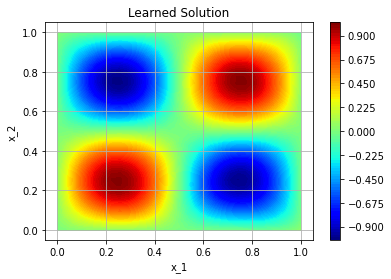

In [87]:
# Plot the solution

plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=1000)
fig = tp.utils.plot(model=model, plot_function=lambda u : u, point_sampler=plot_sampler,
                    plot_type="contour_surface")
plt.title("Learned Solution")

Text(0.5, 1.0, 'Difference to real Solution')

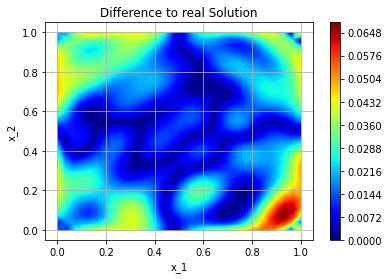

In [88]:
# Plot the error
def plot_fn(u, x):
    real_solution = torch.sin(2*math.pi*x[:, :1]) *torch.sin(2*math.pi*x[:, 1:])
    return torch.abs(u - real_solution)

plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=1000)
fig = tp.utils.plot(model=model, 
                    plot_function=plot_fn, 
                    point_sampler=plot_sampler,
                    plot_type="contour_surface")
plt.title("Difference to real Solution")